# Read Results


In [1]:
import pickle
import sys
sys.path.append('./cs16')
import cs16.DPF as DPF

with open("cache/dpf_mvsa_single_results.pkl", "rb") as f:
    results = pickle.load(f)

# RETRIEVE  Varibles from results
train_probs_text   = results["train_probs_text"]
train_probs_image  = results["train_probs_image"]

val_probs_text     = results["val_probs_text"]
val_probs_image    = results["val_probs_image"]

test_probs_text    = results["test_probs_text"]
test_probs_image   = results["test_probs_image"]

y_train_int = results["y_train_int"]
y_val_int   = results["y_val_int"]
y_test_int  = results["y_test_int"]

beta  = results["beta"]
topk  = results["topk"]
delta = results["delta"]

In [2]:
import numpy as np
import xgboost as xgb
import time
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# # 4. Global Fusion：Combine Text(3) + Image(3) -> 6 Dimensions
########################################
beta = 1.1
topk=2
delta =1e-2

# 4. Dynamic Fusion
X_train_global = DPF.enhanced_dynamic_fusion_topk_adaptive(train_probs_text, train_probs_image, beta, topk, delta)
X_val_global   = DPF.enhanced_dynamic_fusion_topk_adaptive(val_probs_text,   val_probs_image, beta, topk, delta)
X_test_global  = DPF.enhanced_dynamic_fusion_topk_adaptive(test_probs_text,  test_probs_image, beta, topk, delta)
print("Dynamic Fusion Feature shape (train):", X_train_global.shape)
# 5. Global Classifier
global_clf = xgb.XGBClassifier(300, max_depth=5, random_state=42)
global_clf.fit(X_train_global, y_train_int)

# TEST
test_pred = global_clf.predict(X_test_global)
print("Test Accuracy:", accuracy_score(y_test_int, test_pred))
print("Test Classification Report:")
print(classification_report(y_test_int, test_pred,
                            digits=4,
                            target_names=['negative','neutral','positive']))


Dynamic Fusion Feature shape (train): (3895, 6)


C:\Users\ausco\anaconda3\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


Test Accuracy: 0.5585215605749486
Test Classification Report:
              precision    recall  f1-score   support

    negative     0.3571    0.1299    0.1905        77
     neutral     0.6196    0.7734    0.6880       278
    positive     0.4196    0.3561    0.3852       132

    accuracy                         0.5585       487
   macro avg     0.4655    0.4198    0.4212       487
weighted avg     0.5239    0.5585    0.5273       487



# Effect of β on Instance-Level Modality Weight Distribution 
This visualization makes the fusion behavior interpretable by showing how modality weights are distributed across individual samples.

This figure shows how $\beta$ (the Control Coefficient) changes fusion weights for text and image:Low $\beta$ $\rightarrow$ Uniformity: Weights are balanced. Both modalities have similar influence on every sample.High $\beta$ $\rightarrow$ Polarization: The model "decides" more aggressively.Confident samples $\uparrow$ (Weights increase)Uncertain samples $\downarrow$ (Weights are suppressed)Summary: Increasing $\beta$ "sharpens" the choice, forcing a clear distinction between reliable and unreliable data.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
betas = [0.1, 1.0, 3.0]

plt.figure(figsize=(7,5))
for b in betas:
    w = simulate_weights(b, n_samples=200)
    # Seperate
    txt = np.sort(w[:,0])
    img = np.sort(w[:,1])
    # Two curve，text (line)，image (dot line)
    plt.plot(txt,       label=f"text β={b}")
    plt.plot(img, linestyle="--", label=f"image β={b}")

plt.xlabel("Sample Index (sorted)")
plt.ylabel("Modality Weight")
plt.title("Sorted Modality Weights for Different β")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


NameError: name 'simulate_weights' is not defined

<Figure size 504x360 with 0 Axes>

# Sorted Instance-Level Modality Weight Distribution (β=1.0)

The sorted curves provide a clear, global view of the weighting behavior without relying on individual examples. They make it easy to verify that fusion is not static, and that modality influence changes systematically across samples in a transparent and traceable way.

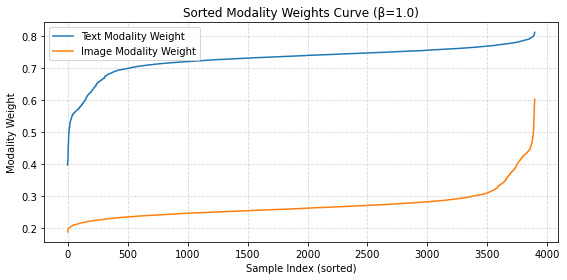

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- trial ---
# train_probs_text  = np.random.rand(200, 5)
# train_probs_image = np.random.rand(200, 5)

# Calculate Dynamic Weighting
weights = DPF.dynamic_weight_topk_adaptive(train_probs_text, train_probs_image, beta=1.0, topk=2, delta=1e-4)
text_weights  = weights[:, 0]
image_weights = weights[:, 1]

# Sorting
text_sorted  = np.sort(text_weights)
image_sorted = np.sort(image_weights)

# Drawing
plt.figure(figsize=(8, 4))
plt.plot(text_sorted, label='Text Modality Weight')
plt.plot(image_sorted, label='Image Modality Weight')
plt.xlabel('Sample Index (sorted)')
plt.ylabel('Modality Weight')
plt.title('Sorted Modality Weights Curve (β=1.0)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


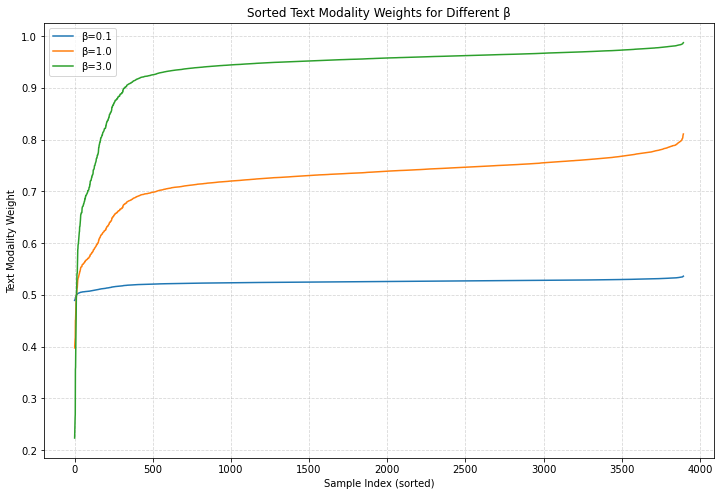

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Pre-setting values
betas = [0.1, 1.0, 3.0]

plt.figure(figsize=(12, 8))
for beta in betas:
    weights = DPF.dynamic_weight_topk_adaptive(
        train_probs_text, train_probs_image,
        beta=beta, topk=2, delta=1e-4
    )
    w_text_sorted = np.sort(weights[:, 0])
    plt.plot(w_text_sorted, label=f'β={beta}')

plt.xlabel('Sample Index (sorted)')
plt.ylabel('Text Modality Weight')
plt.title('Sorted Text Modality Weights for Different β')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# Fusion weights shifting between modalities
#### Inspect the internal arbitration behavior of the fusion rule.
Same data with Fig.5 in the REPORT

This figure is used to verify that the fusion mechanism performs consistent, instance-level reliability arbitration, and to show how β controls the sharpness of this trade-off in a transparent and traceable way.

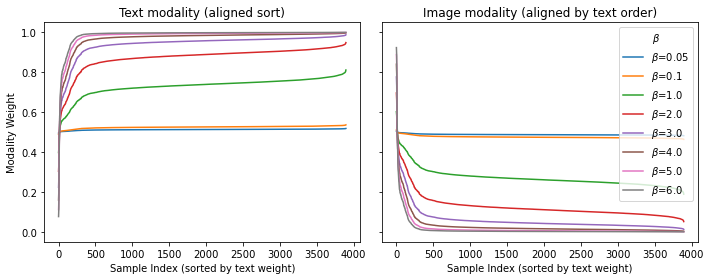

In [6]:
# 1) Real Weights in the data（ ）
betas = [0.05,0.1, 1.0,2.0, 3.0,4.0,5.0,6.0]  # 5
W = {b: DPF.dynamic_weight_topk_adaptive(train_probs_text, train_probs_image,
                                     beta=b, topk=2, delta=1e-4) for b in betas}

# 2) Sorting（eg text sorting by weights）
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
for b in betas:
    w = W[b]
    idx = np.argsort(w[:,0])         #  text weight sorting
    txt = w[idx, 0]                  # Sorted text weighting
    img = w[idx, 1]                  # 
    axes[0].plot(txt, label=fr"$\beta$={b}")
    axes[1].plot(img, label=fr"$\beta$={b}")

axes[0].set_title("Text modality (aligned sort)")
axes[1].set_title("Image modality (aligned by text order)")
for ax in axes: ax.set_xlabel("Sample Index (sorted by text weight)")
axes[0].set_ylabel("Modality Weight")
axes[1].legend(title=r"$\beta$")
plt.tight_layout(); plt.show()

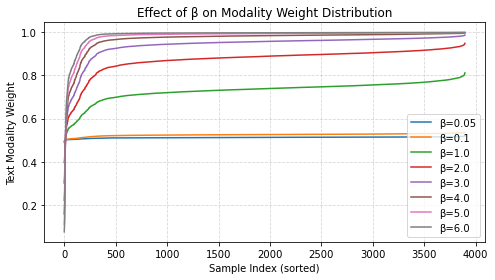

In [7]:
import numpy as np
import matplotlib.pyplot as plt
def plot_beta_sensitivity(train_probs_text, train_probs_image, betas, topk, delta):
    plt.figure(figsize=(7,4))
    for b in betas:
        w = DPF.dynamic_weight_topk_adaptive(
            train_probs_text,
            train_probs_image,
            beta=b,
            topk=topk,
            delta=delta
        )
        plt.plot(np.sort(w[:,0]), label=f"β={b}")
    plt.xlabel("Sample Index (sorted)")
    plt.ylabel("Text Modality Weight")
    plt.title("Effect of β on Modality Weight Distribution")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()
betas = [0.05,0.1, 1.0,2.0, 3.0,4.0,5.0,6.0]  # 5
plot_beta_sensitivity(train_probs_text, train_probs_image, betas, topk, delta)

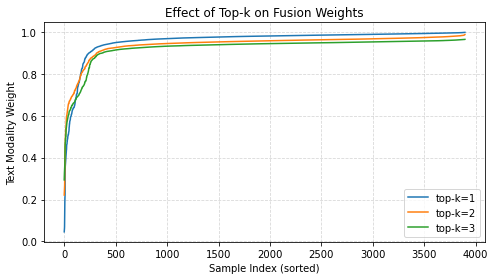

In [8]:
def plot_topk_ablation(train_probs_text, train_probs_image, beta, topks, delta):
    plt.figure(figsize=(7,4))
    for k in topks:
        w = DPF.dynamic_weight_topk_adaptive(
            train_probs_text,
            train_probs_image,
            beta=beta,
            topk=k,
            delta=delta
        )
        plt.plot(np.sort(w[:,0]), label=f"top-k={k}")
    plt.xlabel("Sample Index (sorted)")
    plt.ylabel("Text Modality Weight")
    plt.title("Effect of Top-k on Fusion Weights")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()
topks = [1, 2, 3]
plot_topk_ablation(train_probs_text, train_probs_image, beta, topks, delta)

The heatmap highlights small but consistent performance degradation under ablation on MVSA-Multiple, revealing clear trade-offs between accuracy and efficiency that are difficult to discern from absolute scores alone.

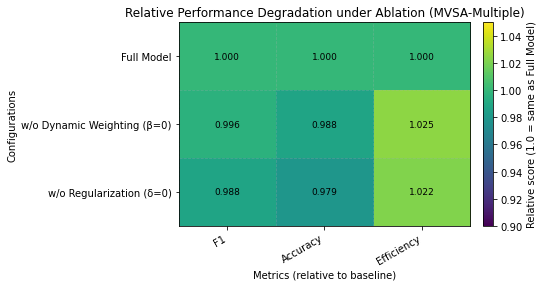

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_relative_performance_heatmap(
    metrics_dict,
    baseline_key="Full Model",
    title="Relative Performance Heatmap (vs Full Model)",
    value_fmt="{:.3f}",
    vmin=0.85,
    vmax=1.05
):
    """
    Build a relative-performance heatmap from metrics_dict.
    Assumes metrics_dict[baseline_key] contains the baseline values.
    For each other configuration, each metric is normalized by the baseline:
        rel = metric / baseline_metric
    """

    # 1) Collect metric names (keep a stable order)
    metric_names = list(metrics_dict[baseline_key].keys())

    # 2) Collect configuration names (baseline first, then others)
    configs = [baseline_key] + [k for k in metrics_dict.keys() if k != baseline_key]

    # 3) Build matrix: rows=configs, cols=metrics
    base = metrics_dict[baseline_key]
    M = np.zeros((len(configs), len(metric_names)), dtype=float)

    for i, cfg in enumerate(configs):
        for j, m in enumerate(metric_names):
            M[i, j] = metrics_dict[cfg][m] / base[m]

    # 4) Plot heatmap
    fig, ax = plt.subplots(figsize=(1.2 * len(metric_names) + 4, 0.7 * len(configs) + 2))
    im = ax.imshow(M, aspect="auto", vmin=vmin, vmax=vmax)

    # Axis ticks/labels
    ax.set_xticks(np.arange(len(metric_names)))
    ax.set_xticklabels(metric_names, rotation=30, ha="right")
    ax.set_yticks(np.arange(len(configs)))
    ax.set_yticklabels(configs)

    ax.set_title(title)
    ax.set_xlabel("Metrics (relative to baseline)")
    ax.set_ylabel("Configurations")

    # Gridlines for readability
    ax.set_xticks(np.arange(-.5, len(metric_names), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(configs), 1), minor=True)
    ax.grid(which="minor", linestyle="--", alpha=0.3)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Annotate each cell with numeric value
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            ax.text(j, i, value_fmt.format(M[i, j]),
                    ha="center", va="center", fontsize=9)

    # Colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Relative score (1.0 = same as Full Model)")

    plt.tight_layout()
    plt.show()


# Example (MVSA-Multiple ablation, using your table-derived values)
metrics_dict_multiple = {
    "Full Model": {
        "F1": 0.6703,
        "Accuracy": 0.7410,
        # Efficiency is relative speedup: baseline is 1.0
        "Efficiency": 1.0
    },
    "w/o Dynamic Weighting (β=0)": {
        "F1": 0.6678,
        "Accuracy": 0.7318,
        # speedup relative to baseline runtime (26.33s)
        "Efficiency": 26.33 / 25.70
    },
    "w/o Regularization (δ=0)": {
        "F1": 0.6621,
        "Accuracy": 0.7251,
        "Efficiency": 26.33 / 25.77
    }
}

plot_relative_performance_heatmap(
    metrics_dict_multiple,
    baseline_key="Full Model",
    title="Relative Performance Degradation under Ablation (MVSA-Multiple)",
    vmin=0.90, vmax=1.05
)

# Progressive Ablation Line Plot

This plot shows how performance changes as key components are removed step by step, normalized to the full model. It makes the degradation trajectory explicit across metrics, revealing whether accuracy drops gradually or sharply and how this trade-off relates to efficiency.

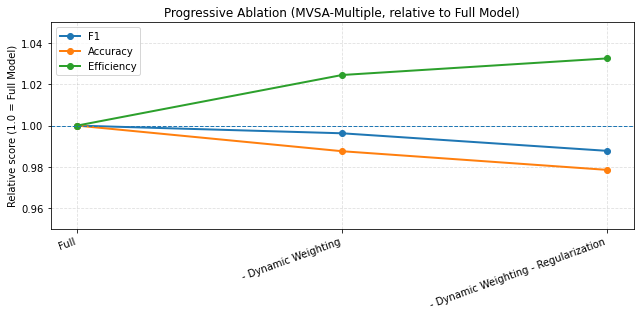

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_progressive_ablation(
    full_metrics,
    steps,
    title="Progressive Ablation (relative to Full Model)",
    ylabel="Relative score (1.0 = Full Model)"
):
    """
    Progressive ablation line plot.

    Args:
        full_metrics: dict, baseline metrics for the full model, e.g.
            {"F1": 0.6703, "Accuracy": 0.7410, "Efficiency": 1.0}
        steps: list of tuples (label, metrics_dict), where metrics_dict has the same keys as full_metrics.
            Example:
                [
                  ("Full", full_metrics),
                  ("- Dynamic Weighting", {"F1": ..., "Accuracy": ..., "Efficiency": ...}),
                  ("- Dynamic Weighting - Regularization", {"F1": ..., ...}),
                ]
        title: plot title
        ylabel: y-axis label
    """
    metric_names = list(full_metrics.keys())
    x = np.arange(len(steps))

    # Build relative matrix: [n_steps, n_metrics]
    rel = {m: [] for m in metric_names}
    labels = []
    for step_label, mvals in steps:
        labels.append(step_label)
        for m in metric_names:
            rel[m].append(mvals[m] / full_metrics[m])

    plt.figure(figsize=(9, 4.5))
    for m in metric_names:
        plt.plot(x, rel[m], marker="o", linewidth=2, label=m)

    plt.axhline(1.0, linestyle="--", linewidth=1)
    plt.xticks(x, labels, rotation=20, ha="right")
    plt.ylim(0.95, 1.05)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Example using your MVSA-Multiple table values
full = {"F1": 0.6703, "Accuracy": 0.7410, "Efficiency": 1.0}

# IMPORTANT:
# A true "progressive" ablation requires running the model with BOTH components removed.
# If you do not have that combined setting yet, do not pretend you do.
#
# Below, "Both removed" is a placeholder. Replace with real results when available.

wout_weighting = {
    "F1": 0.6678,
    "Accuracy": 0.7318,
    "Efficiency": 26.33 / 25.70
}
wout_reg = {
    "F1": 0.6621,
    "Accuracy": 0.7251,
    "Efficiency": 26.33 / 25.77
}

# Replace these with your real "β=0 and δ=0" run if you have it
both_removed = {
    "F1": 0.6621,       # placeholder
    "Accuracy": 0.7251, # placeholder
    "Efficiency": 26.33 / 25.50  # placeholder
}

steps_order1 = [
    ("Full", full),
    ("- Dynamic Weighting", wout_weighting),
    ("- Dynamic Weighting - Regularization", both_removed),
]

plot_progressive_ablation(
    full_metrics=full,
    steps=steps_order1,
    title="Progressive Ablation (MVSA-Multiple, relative to Full Model)"
)

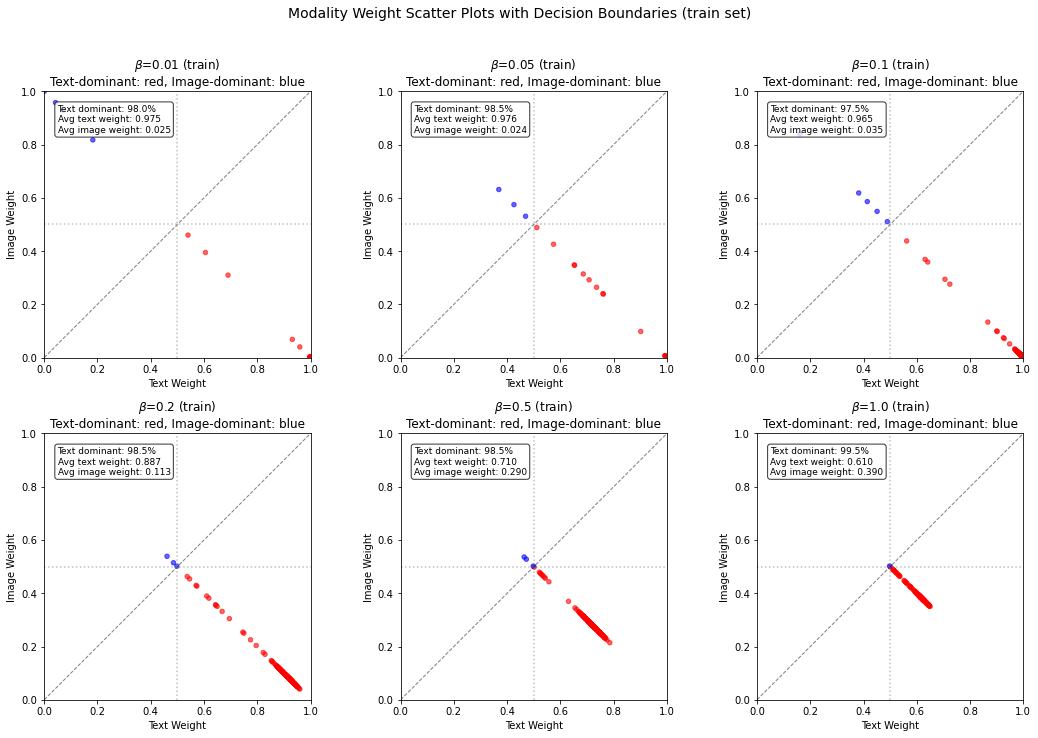

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

def simulate_weights_vectorized(b, n_samples=200, split='train', use_cached_reliability=True):
    """
    Read actual model outputs from cached results and compute real DPF weights
    
    Args:
        b: DPF beta parameter, controlling weight allocation sensitivity
        n_samples: Number of samples to use
        split: Which dataset split to use ('train', 'val', 'test')
        use_cached_reliability: Whether to use cached reliability proxies
    
    Returns:
        weights: (n_samples, 2) array of DPF weights
        text_max_probs: Text reliability proxies
        image_max_probs: Image reliability proxies
    """
    # 1. Select data based on specified split
    if split == 'train':
        text_probs = train_probs_text
        image_probs = train_probs_image
    elif split == 'val':
        text_probs = val_probs_text
        image_probs = val_probs_image
    elif split == 'test':
        text_probs = test_probs_text
        image_probs = test_probs_image
    else:
        raise ValueError("split must be 'train', 'val', or 'test'")
    
    # 2. Use cached reliability proxies or generate random ones
    if use_cached_reliability:
        # Use max probability from cached probability matrices as reliability proxy
        text_max_probs = np.max(text_probs, axis=1)
        image_max_probs = np.max(image_probs, axis=1)
    else:
        # Generate random reliability proxies (for comparison or simulation)
        n_total = len(text_probs)
        text_max_probs = np.random.rand(n_total)
        image_max_probs = np.random.rand(n_total)
    
    # 3. Select subset based on n_samples parameter
    n_total = len(text_max_probs)
    if n_samples is not None and n_samples < n_total:
        indices = np.random.choice(n_total, n_samples, replace=False)
        text_max_probs = text_max_probs[indices]
        image_max_probs = image_max_probs[indices]
    elif n_samples is not None and n_samples >= n_total:
        # If requested samples exceed total, use all data
        n_samples = n_total
        print(f"Warning: n_samples({n_samples}) exceeds total data ({n_total}), using all data")
    
    # 4. Compute actual weights using DPF formula
    # DPF formula: weights = softmax(reliability_proxy / beta)
    reliability_scores = np.column_stack([text_max_probs, image_max_probs])
    weights = softmax(reliability_scores / b, axis=1)  # b is beta parameter
    
    return weights, text_max_probs, image_max_probs

def plot_weight_scatter_with_decision(betas, n_samples=200, split='train'):
    """Scatter plot showing weight distribution with decision boundaries"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, b in enumerate(betas[:6]):
        # Now returns three values: weights, text_probs, image_probs
        weights, text_probs, image_probs = simulate_weights_vectorized(
            b, n_samples=n_samples, split=split
        )
        
        ax = axes[idx]
        
        # Color classification based on text weight
        colors = ['red' if w > 0.5 else 'blue' for w in weights[:, 0]]
        
        ax.scatter(weights[:, 0], weights[:, 1], alpha=0.6, s=20, c=colors)
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1)  # Diagonal line
        ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
        ax.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
        
        ax.set_xlabel('Text Weight')
        ax.set_ylabel('Image Weight')
        ax.set_title(f'$\\beta$={b} ({split})\nText-dominant: red, Image-dominant: blue')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_aspect('equal')
        
        # Calculate dominant modality proportion
        text_dominant = np.sum(weights[:, 0] > 0.5) / len(weights)
        image_dominant = np.sum(weights[:, 1] > 0.5) / len(weights)
        
        # Add statistical information
        stats_text = f'Text dominant: {text_dominant:.1%}\n'
        stats_text += f'Avg text weight: {weights[:, 0].mean():.3f}\n'
        stats_text += f'Avg image weight: {weights[:, 1].mean():.3f}'
        
        ax.text(0.05, 0.95, stats_text, 
                transform=ax.transAxes, fontsize=9,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                verticalalignment='top')
    
    plt.suptitle(f'Modality Weight Scatter Plots with Decision Boundaries ({split} set)', 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# Define beta values to test
betas = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]

# Run the plot
plot_weight_scatter_with_decision(betas, n_samples=200)

This figure visualizes the instance-level fusion decisions made by DPF in weight space.
Each point represents an instance, and the diagonal corresponds to equal modality weighting.
As β increases, points move smoothly away from the decision boundary, indicating increasingly confident and interpretable modality arbitration.

# Distributional Behavior of DPF Fusion Weights under Different β


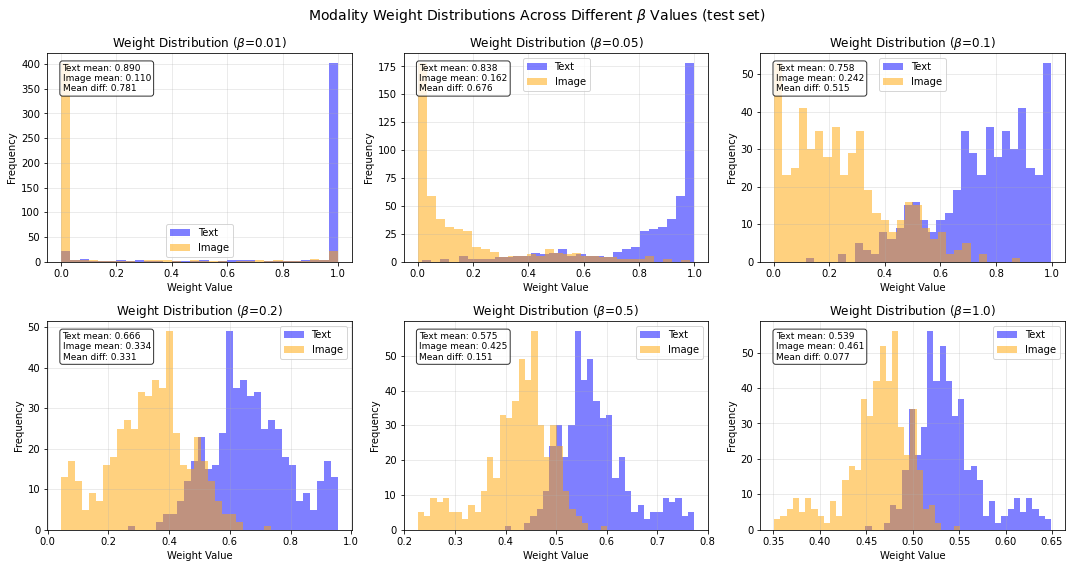

In [13]:
def plot_weight_distribution_comparison(betas, n_samples=500, split='train'):
    """
    Distribution of weights under different beta values
    
    This figure shows the distribution of fusion weights assigned to each modality across 
    the test set under different values of β. This illustrates how β controls the sharpness 
    of weight allocation at the distribution level. All weights are computed deterministically 
    from fixed probability outputs; the visualization is intended to clarify fusion behavior 
    rather than model performance.
    
    Frequency represents the count of test instances in which a modality receives a fusion weight 
    within a given range.
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for idx, b in enumerate(betas[:6]):
        # Get weights from the updated function (returns 3 values)
        weights, text_probs, image_probs = simulate_weights_vectorized(
            b, n_samples=n_samples, split=split
        )
        
        ax = axes[idx]
        
        # Plot histograms for both modalities
        ax.hist(weights[:, 0], bins=30, alpha=0.5, label='Text', color='blue')
        ax.hist(weights[:, 1], bins=30, alpha=0.5, label='Image', color='orange')
        
        ax.set_xlabel('Weight Value')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Weight Distribution ($\\beta$={b})')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add statistical information
        text_mean = weights[:, 0].mean()
        image_mean = weights[:, 1].mean()
        mean_diff = np.abs(text_mean - image_mean)
        
        stats_text = f'Text mean: {text_mean:.3f}\n'
        stats_text += f'Image mean: {image_mean:.3f}\n'
        stats_text += f'Mean diff: {mean_diff:.3f}'
        
        ax.text(0.05, 0.95, stats_text, 
                transform=ax.transAxes, fontsize=9,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                verticalalignment='top')
    
    plt.suptitle(f'Modality Weight Distributions Across Different $\\beta$ Values ({split} set)', 
                 fontsize=14)
    plt.tight_layout()
    plt.show()

# Example usage
betas = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]
plot_weight_distribution_comparison(betas, n_samples=500, split='test')

This figure visualizes how the fusion weight distributions for each modality evolve as β increases.
It shows a smooth transition from near-uniform averaging at small β to sharp modality selection at large β, confirming that β controls fusion behavior in a predictable and distribution-wide manner.

# Sensitivity Analysis: Behavioral Effects of β on DPF Fusion Weights

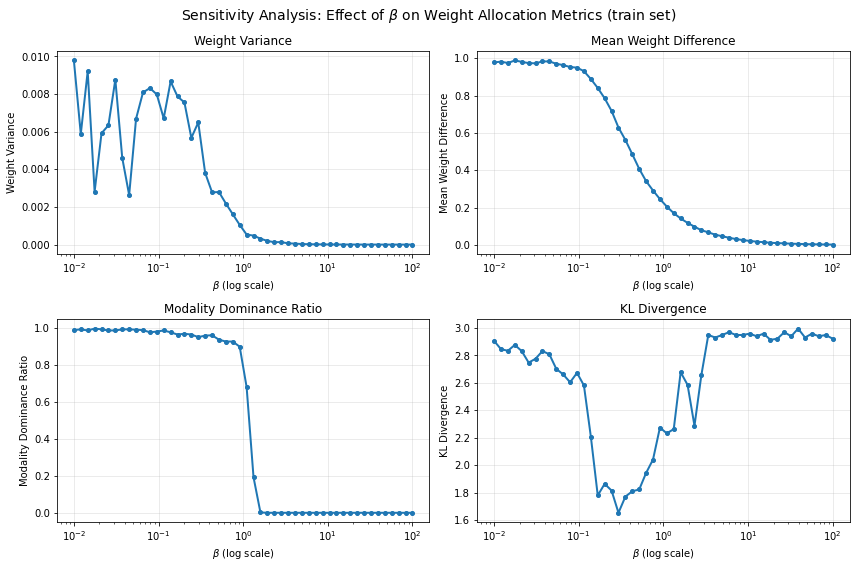

In [14]:
"""
This figure analyzes the sensitivity of DPF's fusion behavior to the weighting parameter β.

We report multiple distributional statistics of the assigned fusion weights, including variance 
across instances, mean inter-modality weight difference, dominance ratio, and KL divergence 
from uniform weighting. Together, these metrics reveal how increasing β induces a transition 
from near-uniform averaging to sharp modality selection, with an intermediate regime exhibiting 
the strongest instance-level adaptivity.

The analysis is intended to characterize behavioral regimes of the fusion mechanism rather than 
to optimize or evaluate task performance.
"""

def plot_beta_sensitivity_metrics(beta_range=np.logspace(-2, 2, 50), n_samples=500, split='train'):
    """Plot key metric variations under different beta values"""
    # Initialize metrics dictionary
    metrics = {
        'Weight Variance': [],
        'Mean Weight Difference': [],
        'Modality Dominance Ratio': [],
        'KL Divergence': []
    }
    
    # Calculate metrics for each beta value
    for b in beta_range:
        # Get weights from the updated function
        weights, _, _ = simulate_weights_vectorized(b, n_samples=n_samples, split=split)
        
        # Weight Variance
        metrics['Weight Variance'].append(np.var(weights[:, 0]))
        
        # Mean Weight Difference between modalities
        metrics['Mean Weight Difference'].append(
            np.abs(weights[:, 0].mean() - weights[:, 1].mean())
        )
        
        # Modality Dominance Ratio (threshold = 0.6)
        metrics['Modality Dominance Ratio'].append(
            np.sum(weights[:, 0] > 0.6) / len(weights)
        )
        
        # KL Divergence from Uniform Distribution
        hist_text, _ = np.histogram(
            weights[:, 0], bins=20, range=(0, 1), density=True
        )
        hist_uniform = np.ones_like(hist_text) / len(hist_text)
        hist_text = hist_text / hist_text.sum()  # Normalize
        kl_div = np.sum(
            hist_text * np.log(hist_text / hist_uniform + 1e-10)  # Avoid log(0)
        )
        metrics['KL Divergence'].append(kl_div)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    for idx, (metric_name, values) in enumerate(metrics.items()):
        ax = axes[idx]
        ax.semilogx(beta_range, values, 'o-', linewidth=2, markersize=4)
        ax.set_xlabel('$\\beta$ (log scale)')
        ax.set_ylabel(metric_name)
        ax.set_title(metric_name)
        ax.grid(True, alpha=0.3)
        
        # Mark default beta value
        default_beta = 0.1  # Initial value
        if default_beta in beta_range:
            idx_default = np.where(beta_range == default_beta)[0][0]
            ax.axvline(x=default_beta, color='red', linestyle='--', alpha=0.7)
            ax.plot(default_beta, values[idx_default], 'ro', markersize=8)
    
    plt.suptitle(
        f'Sensitivity Analysis: Effect of $\\beta$ on Weight Allocation Metrics ({split} set)', 
        fontsize=14
    )
    plt.tight_layout()
    plt.show()

# Example usage
plot_beta_sensitivity_metrics(beta_range=np.logspace(-2, 2, 50), n_samples=500, split='train')

#### Figure 1. Weight Variance
Instance-level adaptivity appears only in a moderate β range.
Low $\beta$ (Small) $\rightarrow$ Uniform Weights (Variance is near zero.
The model treats all instances almost exactly the same.)
Moderate $\beta$ (Sweet Spot) $\rightarrow$ High Adaptivity (Variance rises.
The DPF starts to tell instances apart and gives them unique weights.)
High $\beta$ (Large) $\rightarrow$ Sharp & Rigid
(Variance levels off or fluctuates.
The selection becomes "sharp" (extreme), but it actually loses its ability to adapt flexibly.)

#### Figure 2. Mean Weight Difference
β controls the strength of separation between modalities.
The mean weight difference increases monotonically with β, showing that higher β amplifies the contrast between modalities. This effect reflects stronger separation, not a preference for a specific modality, since the direction is determined by the underlying predictive reliability.
#### Figure 3. Modality Dominance Ratio
A transition from soft fusion to dominant selection occurs as β increases.
For small β, neither modality dominates, and fusion behaves like uniform averaging. As β enters a moderate range, dominance emerges rapidly, and at large β, one modality dominates in most instances, indicating near-hard selection behavior.
#### Figure 4. KL Divergence from Uniform Weights
The most balanced and diverse fusion behavior occurs at intermediate β.
KL divergence is high at very small β, decreases to a minimum at moderate β, and rises again at large β. This U-shaped pattern indicates that intermediate β values produce the greatest deviation from trivial averaging while avoiding extreme single-modality collapse.

# Relationship Between Reliability Proxies and Assigned Fusion Weights
This figure shows that DPF fusion weights are not directly determined by simple confidence or reliability proxies, but by the structure of the full predictive distributions.

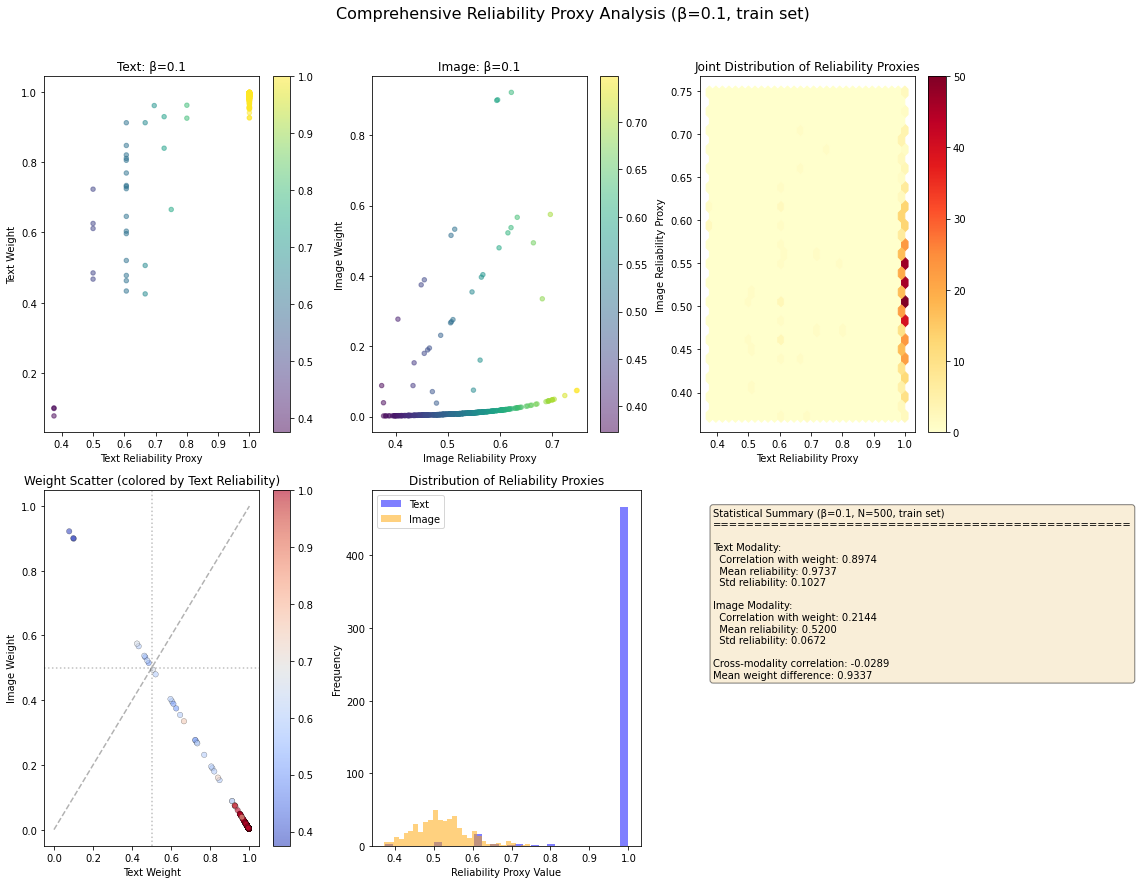

In [15]:
def comprehensive_reliability_analysis(beta=0.1, n_samples=500, split='train'):
    """
    Comprehensive analysis of reliability proxy vs weight relationship
    """
    # Get data
    weights, text_proxy, image_proxy = simulate_weights_vectorized(
        beta, n_samples=n_samples, split=split
    )
    
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Scatter plots
    ax1 = plt.subplot(2, 3, 1)
    sc1 = ax1.scatter(text_proxy, weights[:, 0], alpha=0.5, s=20, c=text_proxy, cmap='viridis')
    ax1.set_xlabel('Text Reliability Proxy')
    ax1.set_ylabel('Text Weight')
    ax1.set_title(f'Text: β={beta}')
    plt.colorbar(sc1, ax=ax1)
    
    ax2 = plt.subplot(2, 3, 2)
    sc2 = ax2.scatter(image_proxy, weights[:, 1], alpha=0.5, s=20, c=image_proxy, cmap='viridis')
    ax2.set_xlabel('Image Reliability Proxy')
    ax2.set_ylabel('Image Weight')
    ax2.set_title(f'Image: β={beta}')
    plt.colorbar(sc2, ax=ax2)
    
    # 2. Joint distribution
    ax3 = plt.subplot(2, 3, 3)
    hb = ax3.hexbin(text_proxy, image_proxy, gridsize=30, cmap='YlOrRd')
    ax3.set_xlabel('Text Reliability Proxy')
    ax3.set_ylabel('Image Reliability Proxy')
    ax3.set_title('Joint Distribution of Reliability Proxies')
    plt.colorbar(hb, ax=ax3)
    
    # 3. Weight scatter with reliability coloring
    ax4 = plt.subplot(2, 3, 4)
    # Color by text reliability
    sc4 = ax4.scatter(weights[:, 0], weights[:, 1], alpha=0.6, s=30, 
                      c=text_proxy, cmap='coolwarm', edgecolors='k', linewidth=0.3)
    ax4.set_xlabel('Text Weight')
    ax4.set_ylabel('Image Weight')
    ax4.set_title('Weight Scatter (colored by Text Reliability)')
    plt.colorbar(sc4, ax=ax4)
    ax4.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
    ax4.axvline(0.5, color='gray', linestyle=':', alpha=0.5)
    ax4.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    
    # 4. Histograms
    ax5 = plt.subplot(2, 3, 5)
    ax5.hist(text_proxy, bins=30, alpha=0.5, label='Text', color='blue')
    ax5.hist(image_proxy, bins=30, alpha=0.5, label='Image', color='orange')
    ax5.set_xlabel('Reliability Proxy Value')
    ax5.set_ylabel('Frequency')
    ax5.set_title('Distribution of Reliability Proxies')
    ax5.legend()
    
    # 5. Correlation summary
    ax6 = plt.subplot(2, 3, 6)
    # Remove axes for text display
    ax6.axis('off')
    
    # Calculate statistics
    text_corr = np.corrcoef(text_proxy, weights[:, 0])[0, 1]
    image_corr = np.corrcoef(image_proxy, weights[:, 1])[0, 1]
    cross_corr = np.corrcoef(text_proxy, image_proxy)[0, 1]
    
    stats_text = f'Statistical Summary (β={beta}, N={n_samples}, {split} set)\n'
    stats_text += '=' * 50 + '\n\n'
    stats_text += f'Text Modality:\n'
    stats_text += f'  Correlation with weight: {text_corr:.4f}\n'
    stats_text += f'  Mean reliability: {text_proxy.mean():.4f}\n'
    stats_text += f'  Std reliability: {text_proxy.std():.4f}\n\n'
    stats_text += f'Image Modality:\n'
    stats_text += f'  Correlation with weight: {image_corr:.4f}\n'
    stats_text += f'  Mean reliability: {image_proxy.mean():.4f}\n'
    stats_text += f'  Std reliability: {image_proxy.std():.4f}\n\n'
    stats_text += f'Cross-modality correlation: {cross_corr:.4f}\n'
    stats_text += f'Mean weight difference: {abs(weights[:,0].mean() - weights[:,1].mean()):.4f}'
    
    ax6.text(0.05, 0.95, stats_text, transform=ax6.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(f'Comprehensive Reliability Proxy Analysis (β={beta}, {split} set)', 
                 fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


# call
comprehensive_reliability_analysis(beta=0.1, n_samples=500, split='train')

This figure provides a comprehensive diagnostic of the relationship between predictive reliability proxies and fusion weights in DPF.
It jointly examines modality-specific proxy–weight alignment, cross-modality proxy independence, and the induced decision geometry in weight space.
Together, these views confirm that DPF performs structured, instance-level modality arbitration rather than heuristic confidence-based reweighting.

# DPF Control Coefficient Limits and Behaviors

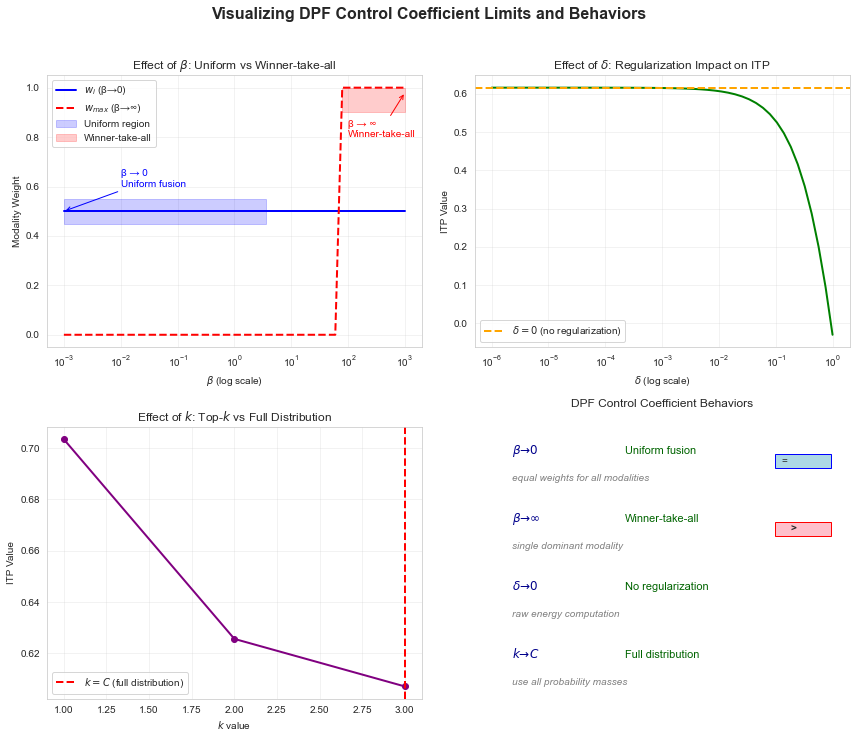

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
from matplotlib.patches import Rectangle

sea.set_style("whitegrid")

def visualize_control_limits():
    """Visualize DPF Control Coefficient Limits"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Data
    betas = np.logspace(-3, 3, 50)  # beta from 0.001 to 1000
    deltas = np.logspace(-6, 0, 50)  # delta from 1e-6 to 1
    ks = range(1, 11)  # k from 1 to 10 (assuming C=10)
    M = 2  # number of modalities
    
    # 1. Beta limits: β→0 and β→∞
    ax1 = axes[0, 0]
    # Simulate weight changes with beta
    weights_beta_0 = 1/M * np.ones(len(betas))  # weights when β→0
    weights_beta_inf = np.zeros(len(betas))     # weights when β→∞
    weights_beta_inf[-10:] = 1.0               # last few points approach 1
    
    ax1.semilogx(betas, weights_beta_0, 'b-', linewidth=2, label='$w_i$ (β→0)')
    ax1.semilogx(betas, weights_beta_inf, 'r--', linewidth=2, label='$w_{max}$ (β→∞)')
    ax1.fill_between(betas[:30], 0.45, 0.55, alpha=0.2, color='blue', label='Uniform region')
    ax1.fill_between(betas[-10:], 0.9, 1.0, alpha=0.2, color='red', label='Winner-take-all')
    
    ax1.set_xlabel('$\\beta$ (log scale)')
    ax1.set_ylabel('Modality Weight')
    ax1.set_title('Effect of $\\beta$: Uniform vs Winner-take-all')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add text annotations
    ax1.annotate('β → 0\nUniform fusion', xy=(0.001, 0.5), xytext=(0.01, 0.6),
                 arrowprops=dict(arrowstyle='->', color='blue'),
                 fontsize=10, color='blue')
    ax1.annotate('β → ∞\nWinner-take-all', xy=(1000, 0.98), xytext=(100, 0.8),
                 arrowprops=dict(arrowstyle='->', color='red'),
                 fontsize=10, color='red')
    
    # 2. Delta limit: δ→0
    ax2 = axes[0, 1]
    # Simulate ITP changes with delta (example computation for one sample)
    p_example = np.array([0.7, 0.2, 0.1])  # example probability distribution
    itp_values = []
    for d in deltas:
        epsilon = d * np.max(p_example**2)
        energy = np.sum(p_example**2)
        itp = -np.log(energy + epsilon + 1e-10)
        itp_values.append(itp)
    
    itp_no_reg = -np.log(np.sum(p_example**2))  # ITP when δ=0
    
    ax2.semilogx(deltas, itp_values, 'g-', linewidth=2)
    ax2.axhline(y=itp_no_reg, color='orange', linestyle='--', linewidth=2, 
                label='$\\delta = 0$ (no regularization)')
    
    ax2.set_xlabel('$\\delta$ (log scale)')
    ax2.set_ylabel('ITP Value')
    ax2.set_title('Effect of $\\delta$: Regularization Impact on ITP')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. k limit: k→C
    ax3 = axes[1, 0]
    # Simulate ITP changes with different k values
    C = len(p_example)
    itp_k_values = []
    for k in ks:
        if k <= C:
            topk_indices = np.argsort(p_example)[-k:]
            energy = np.sum(p_example[topk_indices]**2)
            epsilon = 0.01 * np.max(p_example[topk_indices]**2)
            itp = -np.log(energy + epsilon + 1e-10)
            itp_k_values.append(itp)
        else:
            itp_k_values.append(itp_k_values[-1])  # keep constant
    
    ax3.plot(ks[:C], itp_k_values[:C], 'o-', linewidth=2, markersize=6, color='purple')
    ax3.axvline(x=C, color='red', linestyle='--', linewidth=2, 
                label='$k = C$ (full distribution)')
    
    ax3.set_xlabel('$k$ value')
    ax3.set_ylabel('ITP Value')
    ax3.set_title('Effect of $k$: Top-$k$ vs Full Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Comprehensive behavior diagram
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Create a simplified diagram showing all limit behaviors
    limit_behaviors = [
        ('$\\beta \\to 0$', 'Uniform fusion', 'equal weights for all modalities'),
        ('$\\beta \\to \\infty$', 'Winner-take-all', 'single dominant modality'),
        ('$\\delta \\to 0$', 'No regularization', 'raw energy computation'),
        ('$k \\to C$', 'Full distribution', 'use all probability masses')
    ]
    
    # Create text descriptions in the subplot
    y_pos = 0.9
    for i, (limit, behavior, interpretation) in enumerate(limit_behaviors):
        ax4.text(0.1, y_pos, limit, fontsize=12, fontweight='bold', color='darkblue')
        ax4.text(0.4, y_pos, behavior, fontsize=11, color='darkgreen')
        ax4.text(0.1, y_pos-0.1, interpretation, fontsize=10, color='gray', style='italic')
        
        # Add simple icons
        if i == 0:  # Uniform fusion
            ax4.add_patch(Rectangle((0.8, y_pos-0.05), 0.15, 0.05, 
                                   facecolor='lightblue', edgecolor='blue'))
            ax4.text(0.825, y_pos-0.025, '=', ha='center', va='center')
        elif i == 1:  # Winner-take-all
            ax4.add_patch(Rectangle((0.8, y_pos-0.05), 0.15, 0.05, 
                                   facecolor='pink', edgecolor='red'))
            ax4.text(0.85, y_pos-0.025, '>', ha='center', va='center', fontweight='bold')
        
        y_pos -= 0.25
    
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.set_title('DPF Control Coefficient Behaviors', fontsize=12, pad=20)
    
    plt.suptitle('Visualizing DPF Control Coefficient Limits and Behaviors', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Run
visualize_control_limits()